<a href="https://colab.research.google.com/github/fedhere/PUS2020_FBianco/blob/master/HW6/DEelectoralHW6_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import scipy as sp
import pylab as plt
import shapely

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
!pip install geopandas

     |████████████████████████████████| 972kB 2.8MB/s 
     |████████████████████████████████| 10.9MB 13.9MB/s 
     |████████████████████████████████| 14.8MB 286kB/s 


In [ ]:
!pip install -U --no-deps mapclassify git+git://github.com/geopandas/geopandas.git@master


  Cloning git://github.com/geopandas/geopandas.git (to revision master) to /tmp/pip-req-build-7iwf0o06
  Running command git clone -q git://github.com/geopandas/geopandas.git /tmp/pip-req-build-7iwf0o06
  Created wheel for geopandas: filename=geopandas-0.8.0+55.g924cdf6-py2.py3-none-any.whl size=970002 sha256=8cabf529fac11046c5e4f7adc8d948135dabe1ca04ee6bdd6607bfa9f7d6d1f0
  Stored in directory: /tmp/pip-ephem-wheel-cache-vzrc41zi/wheels/1e/57/dc/7a5ea8503aefb23576c42181adfca7fc173fde5b71900660bc
Successfully built geopandas
  Found existing installation: geopandas 0.8.1
    Uninstalling geopandas-0.8.1:
      Successfully uninstalled geopandas-0.8.1


In [ ]:
!apt install libspatialindex-c4v5
!pip install pysal

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
0 upgraded, 2 newly installed, 0 to remove and 21 not upgraded.
Need to get 270 kB of archives.
After this operation, 1,107 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Fetched 270 kB in 1s (420 kB/s)
Selecting previously unselected package libspatialindex4v5:amd64.
(Reading database ... 144611 files and directories currently installed.)
Preparing to unpack .../libspatialindex4v5_1.8.5-5_amd64.deb ...
Unpacking libspatialindex4v5:amd64 (1.8.5-5) ...
Selecting previously unselected package libspatialindex-c4v5:amd64.
Preparing to u

In [ ]:
import geopandas as gpd

In [ ]:
import pysal as ps

Use the delaware opendata to extract the voting precincts geometries

https://opendata.firstmap.delaware.gov/datasets/delaware-election-boundaries

USe the election data from the turnout project to get the precinct turnout

https://raw.githubusercontent.com/openelections/openelections-data-de/master/2018/20181106__de__general__precinct.csv

# Start from your HW5 (or from the solution posted)

You will need to rerun it and make dure that 
- there are no nan values. Since a lot of the analysis you do relies on population density this will have to be done by **removing areas of 0 population** 
- after you remove precints fix the index by calling ```df_.reset_index(inplace=True)``` on your dataframe so that it does not have missing value. if it did you would be in trouble after creating the weight: you would get a missing index value (I got it for index 274) and also you might have troubles when fitting a line to the Moran's I
- make sure you convert the dataframe to feet (epsg=2263) and work your spatial analysis in feet (there is one point in which I will give you the coordinates of a specific locatoin in lat and lon: you need to either convert those in feet or reconvert temporarily the dataframe to lat-lon to do that part of the analysis)
- make sure you select a single race! the vanilla analysis we did in HW5 could work with summing all the races, but if we want to really look at voters turout, and especially voter turnout by political party and analysis blue and red votes separately, we need to make sure we do not doublecount. I chose the U.S. Senate race. If this were a real project you would need to check if choosing another rate changes your result.

NOTE: I care mostly about the interpretation of the figures in this notebook more than ever! if you cannot get a piece of code to reproduce the figure ask me. I do want you to try (so I want you to ask for it on a step by step basis), but I am happy to show you the solution. I really care about the considerations and interpretation tho!


# read in data

## read in electoral precinct geojson file in geopandas (directly from the URL)

In [120]:
# leave
de_elecp = gpd.read_file("https://opendata.arcgis.com/datasets/91c1f132c7d34885983c56b47dc675fd_0.geojson")



In [ ]:
# leave
de_elecp.head()

,OBJECTID,ID,EDRD_2012,POPULATION,DISTRICT,EGIS_OWNERElection_ED_RD_2012AREA,geometry
0,1,20,01-21,1171,21,None,"POLYGON ((-75.67816 39.74598, -75.67807 39.746..."
1,2,21,01-22,1755,22,None,"POLYGON ((-75.72394 39.76115, -75.72393 39.760..."
2,3,22,01-23,1947,23,None,"POLYGON ((-75.73601 39.68660, -75.73603 39.686..."
3,4,23,01-24,2828,24,None,"POLYGON ((-75.69655 39.66154, -75.69666 39.661..."
4,5,24,01-25,7734,25,None,"POLYGON ((-75.75158 39.65865, -75.75109 39.658..."


In [ ]:
# leave
de_elecp.describe()

,OBJECTID,ID,POPULATION
count,430.000000,430.000000,430.000000
mean,215.500000,216.500000,2088.218605
std,124.274562,124.274562,998.347223
min,1.000000,2.000000,0.000000
25%,108.250000,109.250000,1484.750000
50%,215.500000,216.500000,2141.500000
75%,322.750000,323.750000,2659.750000
max,430.000000,431.000000,7734.000000


## read in turnout data - keep only election district, and votes


In [ ]:
# leave
turnout = pd.read_csv("https://raw.githubusercontent.com/openelections/" + 
                      "openelections-data-de/master/2018/20181106__de__" + 
                      "general__precinct.csv")
turnout = turnout[turnout["office"]=="U.S. Senate"][["party","election_district", "votes"]]

## group by election district and get the total number of data for that district

there are multiple entries for each geometry because there entries indicate the votes per candidate.


In [ ]:
# leave
turnout.groupby(["election_district", "party"]).sum()[["votes"]]

votes
election_district party             
01-01             DEMOCRATIC     581
                  GREEN            5
                  LIBERTARIN       6
                  REPUBLICAN      51
01-02             DEMOCRATIC     694
...                              ...
17-02             REPUBLICAN      14
Total             DEMOCRATIC  217385
                  GREEN         4170
                  LIBERTARIN    3910
                  REPUBLICAN  137127

[1748 rows x 1 columns]

## merge the turnout data with the electoral map


In [ ]:
# remove
de_elecmap = de_elecp.merge(turnout.groupby("election_district").sum()[["votes"]], 
                            left_on="EDRD_2012", right_index=True, how="left")



In [ ]:
# leave this cell to show
no0votesindx = de_elecmap.POPULATION > 0
de_elecmap = de_elecmap[no0votesindx]
de_elecmap.reset_index(inplace=True)

In [ ]:
# leave this cell to show
# note you have 430 precincts with indices 0-429
de_elecmap

,index,OBJECTID,ID,EDRD_2012,POPULATION,DISTRICT,EGIS_OWNERElection_ED_RD_2012AREA,geometry,votes
0,0,1,20,01-21,1171,21,None,"POLYGON ((-75.67816 39.74598, -75.67807 39.746...",528.0
1,1,2,21,01-22,1755,22,None,"POLYGON ((-75.72394 39.76115, -75.72393 39.760...",1109.0
2,2,3,22,01-23,1947,23,None,"POLYGON ((-75.73601 39.68660, -75.73603 39.686...",185.0
3,3,4,23,01-24,2828,24,None,"POLYGON ((-75.69655 39.66154, -75.69666 39.661...",892.0
4,4,5,24,01-25,7734,25,None,"POLYGON ((-75.75158 39.65865, -75.75109 39.658...",682.0
...,...,...,...,...,...,...,...,...,...
423,425,426,424,08-38,2042,38,None,"POLYGON ((-75.12161 38.45119, -75.12186 38.451...",1197.0
424,426,427,425,08-40,1684,40,None,"POLYGON ((-75.43038 38.65207, -75.43017 38.651...",598.0
425,427,428,426,08-41,2785,41,None,"POLYGON ((-75.36290 38.58543, -75.36268 38.585...",531.0
426,428,429,427,09-20,414,20,None,"POLYGON ((-75.27245 38.80446, -75.27254 38.804...",247.0


## make 3 maps: a coropleth of the population by electoral precinct, votes by precinct, and people density. 
Make sure you discuss patterns that appear, and that you consider the odd shape that delaware has in this map.... what is wrong with it? why does it not look like your usual maps of Delaware? how does this affect the descriptive analysis you just did? Make sure you choose appropriate colors maps and scheme to display the colors. Note that the last map may not be trivial to render. log10 function may be halpful (see notebook https://github.com/fedhere/PUS2020_FBianco/blob/master/classdemo/linear_regression_in_detail.ipynb but it is not required to use it) and also consider the individual values in the rows - are any of them unuaual? if there are consider dropping those values.

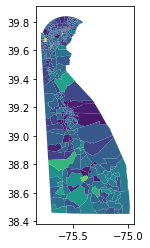

In [ ]:
# leave
# exploratory plot

de_elecmap.plot(column="POPULATION");

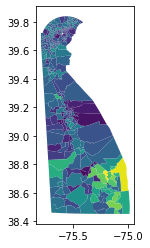

In [ ]:
# leave
# exploratory plot
de_elecmap.plot(column="votes");

In [ ]:
de_elecmap_ft = de_elecmap.to_crs(epsg="2263")
de_elecmap["popdensity"] = (de_elecmap.POPULATION / de_elecmap_ft.geometry.area * 5280 * 5280)


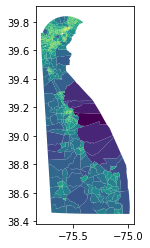

In [ ]:
# leave
de_elecmap.plot(column="popdensity", norm=matplotlib.colors.LogNorm())


In [ ]:
# leave
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [ ]:
# leave
X_train, X_test, y_train, y_test = train_test_split(de_elecmap.POPULATION.values, 
                                                    de_elecmap.votes.values, test_size=0.25, 
                                                     random_state=302)
X_train

# or I can do
np.random.seed(302)
inds = np.sort(np.random.choice(de_elecmap.index, 
                                int(de_elecmap.shape[0] * 0.75), replace=False))

In [ ]:
# remove
de_elecmap_train = de_elecmap[["votes", "POPULATION", "popdensity"]].loc[inds].dropna()
de_elecmap_test = de_elecmap[["votes", "POPULATION", "popdensity"]].loc[
  np.array([i for i in de_elecmap.index if not i in inds ])].dropna()

# This is where HW2 starts

## feature engineering
- create a "voterturnout" variable: the number of votes per person.

- create a "red votes" variable: the number of republican votes per person.

- create a "blue votes" variable: the number of democrat votes per person.

you want all the variable same the same geodataframe

In [ ]:
# remove
df_ = turnout.groupby(["election_district","party"]).sum()
dems = df_[df_.index.get_level_values('party') == "DEMOCRATIC"].rename(
    {"votes":"dems"}, axis=1).reset_index(1).drop("party", axis=1)
reps = df_[df_.index.get_level_values('party') == "REPUBLICAN"].rename(
    {"votes":"reps"}, axis=1).reset_index(1).drop("party", axis=1)


In [ ]:
#leave
dems

,dems
election_district,
01-01,581
01-02,694
01-03,430
01-04,928
01-05,830
...,...
16-04,59
16-31,11
16-41,31


In [ ]:
# remove
de_elecmap_ft = de_elecmap_ft.merge(dems, left_on="EDRD_2012",
                 right_index=True).merge(reps, left_on="EDRD_2012",
                 right_index=True)


In [ ]:
#leave
de_elecmap_ft.head()

,index,OBJECTID,ID,EDRD_2012,POPULATION,DISTRICT,EGIS_OWNERElection_ED_RD_2012AREA,geometry,votes,dems,reps
0,0,1,20,01-21,1171,21,None,"POLYGON ((512298.901 -148744.869, 512327.758 -...",528.0,353,170
1,1,2,21,01-22,1755,22,None,"POLYGON ((499532.843 -142968.932, 499534.031 -...",1109.0,671,411
2,2,3,22,01-23,1947,23,None,"POLYGON ((495603.003 -170059.360, 495596.249 -...",185.0,129,41
3,3,4,23,01-24,2828,24,None,"POLYGON ((506531.023 -179405.605, 506499.398 -...",892.0,582,278
4,4,5,24,01-25,7734,25,None,"POLYGON ((491018.486 -180154.129, 491153.174 -...",682.0,549,97


In [ ]:
# remove
de_elecmap_ft["voterturnout"] = de_elecmap_ft.votes / de_elecmap_ft.POPULATION
de_elecmap_ft["redvotes"] = de_elecmap_ft.reps / de_elecmap_ft.POPULATION
de_elecmap_ft["bluevotes"] = de_elecmap_ft.dems / de_elecmap_ft.POPULATION


In [ ]:
de_elecmap_ft.head()

,index,OBJECTID,ID,EDRD_2012,POPULATION,DISTRICT,EGIS_OWNERElection_ED_RD_2012AREA,geometry,votes,dems,reps,voterturnout,redvotes,bluevotes
0,0,1,20,01-21,1171,21,None,"POLYGON ((512298.901 -148744.869, 512327.758 -...",528.0,353,170,0.450897,0.145175,0.301452
1,1,2,21,01-22,1755,22,None,"POLYGON ((499532.843 -142968.932, 499534.031 -...",1109.0,671,411,0.631909,0.234188,0.382336
2,2,3,22,01-23,1947,23,None,"POLYGON ((495603.003 -170059.360, 495596.249 -...",185.0,129,41,0.095018,0.021058,0.066256
3,3,4,23,01-24,2828,24,None,"POLYGON ((506531.023 -179405.605, 506499.398 -...",892.0,582,278,0.315417,0.098303,0.205799
4,4,5,24,01-25,7734,25,None,"POLYGON ((491018.486 -180154.129, 491153.174 -...",682.0,549,97,0.088182,0.012542,0.070985


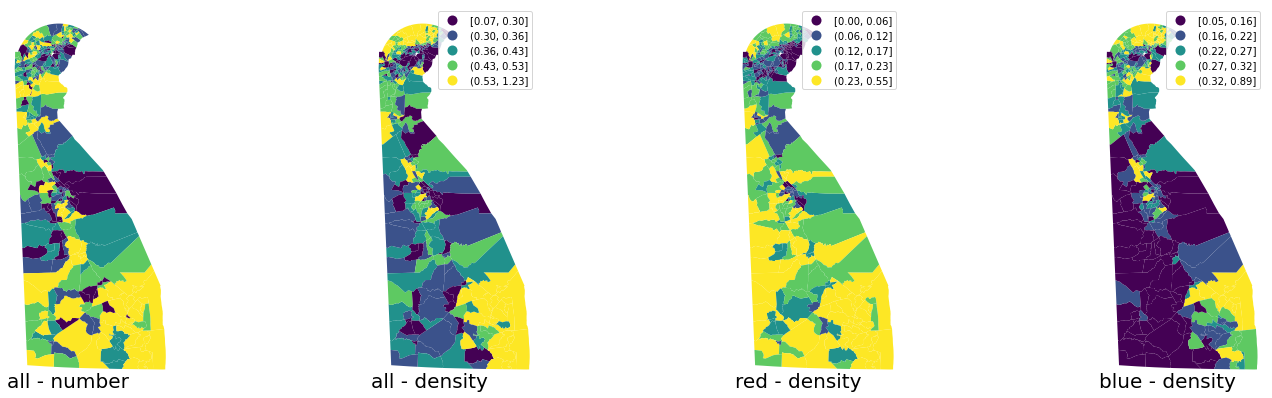

In [ ]:
fig = plt.figure(figsize=(25,7))
ax = fig.add_subplot(141)
de_elecmap_ft.plot(column="votes", k=5, clim=(0.15), linewidth=0.1, ax=ax, 
         legend=False, scheme="quantiles")
ax.axis('off')
ax.text( plt.xlim()[0], plt.ylim()[0], "all - number", fontsize=20)
ax = fig.add_subplot(142)
de_elecmap_ft.plot(column="voterturnout", k=5, clim=(0.15), linewidth=0.1, ax=ax, 
         legend=True, scheme="quantiles")
ax.axis('off')
ax.text( plt.xlim()[0], plt.ylim()[0], "all - density", fontsize=20)
ax = fig.add_subplot(143)
de_elecmap_ft.plot(column="redvotes", k=5, linewidth=0.1, ax=ax, 
         legend=True, scheme="quantiles", clim=(0.15))
ax.axis('off')
ax.text( plt.xlim()[0], plt.ylim()[0], "red - density", fontsize=20)
ax = fig.add_subplot(144)
ax = de_elecmap_ft.plot(column="bluevotes", k=5, linewidth=0.1, ax=ax, 
         legend=True, scheme="quantiles", clim=(0.15))
ax.axis('off')
ax.text(plt.xlim()[0], plt.ylim()[0], "blue - density", fontsize=20);


Figure 1: coropleths of DE electoral districts in 5 quantile intervals. From the left the voters number is shown, the voters density (voter turnout, i.e. voters over population) the Republican Turnout and the Democrats turnout. The most striking features are the high turnout on the south coast and in the wilmington region, the low density of republican votes  in the urban Wilmington area, the low density of democrat voters in the center of the state and high density in urban areas and on the cost.

In [ ]:
de_elecmap_ft = de_elecmap_ft.dropna(subset=["votes"])
de_elecmap_ft.reset_index(inplace=True)

de_elecmap = de_elecmap.dropna(subset=["votes"])
de_elecmap.reset_index(inplace=True)

In [ ]:
# create the rook and queens weights for the DE electoral map geoDF. 
# you can do this by saving the df to a file and calling Rook.from_file (like in the class example) 
# or you can use .from_iterable(geometry) passing the geometry series from the geoDF

from libpysal.weights import Queen, Rook

rook_DE = Rook.from_iterable(de_elecmap_ft.dropna(subset=["votes"]).geometry)
queens_DE = Queen.from_iterable(de_elecmap_ft.dropna(subset=["votes"]).geometry)

In [ ]:
de_elecmap_ft

,level_0,index,OBJECTID,ID,EDRD_2012,POPULATION,DISTRICT,EGIS_OWNERElection_ED_RD_2012AREA,geometry,votes,dems,reps,voterturnout,redvotes,bluevotes
0,0,0,1,20,01-21,1171,21,None,"POLYGON ((512298.901 -148744.869, 512327.758 -...",528.0,353,170,0.450897,0.145175,0.301452
1,1,1,2,21,01-22,1755,22,None,"POLYGON ((499532.843 -142968.932, 499534.031 -...",1109.0,671,411,0.631909,0.234188,0.382336
2,2,2,3,22,01-23,1947,23,None,"POLYGON ((495603.003 -170059.360, 495596.249 -...",185.0,129,41,0.095018,0.021058,0.066256
3,3,3,4,23,01-24,2828,24,None,"POLYGON ((506531.023 -179405.605, 506499.398 -...",892.0,582,278,0.315417,0.098303,0.205799
4,4,4,5,24,01-25,7734,25,None,"POLYGON ((491018.486 -180154.129, 491153.174 -...",682.0,549,97,0.088182,0.012542,0.070985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,423,425,426,424,08-38,2042,38,None,"POLYGON ((662767.289 -623032.929, 662695.364 -...",1197.0,364,818,0.586190,0.400588,0.178257
424,424,426,427,425,08-40,1684,40,None,"POLYGON ((575465.618 -548539.559, 575527.485 -...",598.0,218,369,0.355107,0.219121,0.129454
425,425,427,428,426,08-41,2785,41,None,"POLYGON ((594371.059 -573129.452, 594435.303 -...",531.0,210,309,0.190664,0.110952,0.075404
426,426,428,429,427,09-20,414,20,None,"POLYGON ((621404.971 -493701.642, 621379.547 -...",247.0,80,163,0.596618,0.393720,0.193237


In [ ]:
rook_DE2 = Rook.from_dataframe(de_elecmap_ft.dropna(subset=["votes"]))
queens_DE2 = Queen.from_dataframe(de_elecmap_ft.dropna(subset=["votes"]))

In [ ]:
queens_DE.cardinalities

{0: 7,
 1: 8,
 2: 6,
 3: 9,
 4: 10,
 5: 5,
 6: 5,
 7: 5,
 8: 5,
 9: 10,
 10: 5,
 11: 5,
 12: 5,
 13: 4,
 14: 5,
 15: 5,
 16: 5,
 17: 7,
 18: 8,
 19: 9,
 20: 6,
 21: 8,
 22: 5,
 23: 11,
 24: 5,
 25: 5,
 26: 6,
 27: 10,
 28: 7,
 29: 5,
 30: 5,
 31: 6,
 32: 4,
 33: 5,
 34: 5,
 35: 7,
 36: 5,
 37: 4,
 38: 6,
 39: 6,
 40: 4,
 41: 6,
 42: 4,
 43: 8,
 44: 7,
 45: 4,
 46: 6,
 47: 4,
 48: 11,
 49: 12,
 50: 6,
 51: 7,
 52: 8,
 53: 3,
 54: 4,
 55: 5,
 56: 7,
 57: 5,
 58: 5,
 59: 6,
 60: 6,
 61: 4,
 62: 8,
 63: 8,
 64: 4,
 65: 10,
 66: 9,
 67: 7,
 68: 6,
 69: 4,
 70: 6,
 71: 7,
 72: 9,
 73: 3,
 74: 3,
 75: 3,
 76: 7,
 77: 8,
 78: 5,
 79: 3,
 80: 7,
 81: 4,
 82: 6,
 83: 2,
 84: 8,
 85: 4,
 86: 6,
 87: 5,
 88: 3,
 89: 7,
 90: 5,
 91: 5,
 92: 6,
 93: 5,
 94: 7,
 95: 5,
 96: 8,
 97: 6,
 98: 5,
 99: 4,
 100: 9,
 101: 6,
 102: 5,
 103: 6,
 104: 5,
 105: 7,
 106: 5,
 107: 8,
 108: 7,
 109: 6,
 110: 5,
 111: 8,
 112: 8,
 113: 7,
 114: 3,
 115: 6,
 116: 7,
 117: 7,
 118: 5,
 119: 11,
 120: 4,
 121: 2,
 122

In [ ]:
rook_DE.weights

In [ ]:
rook_DE.cardinalities

In [ ]:
queens_DE.cardinalities

{0: 7,
 1: 8,
 2: 6,
 3: 9,
 4: 10,
 5: 5,
 6: 5,
 7: 5,
 8: 5,
 9: 10,
 10: 5,
 11: 5,
 12: 5,
 13: 4,
 14: 5,
 15: 5,
 16: 5,
 17: 7,
 18: 8,
 19: 9,
 20: 6,
 21: 8,
 22: 5,
 23: 11,
 24: 5,
 25: 5,
 26: 6,
 27: 10,
 28: 7,
 29: 5,
 30: 5,
 31: 6,
 32: 4,
 33: 5,
 34: 5,
 35: 7,
 36: 5,
 37: 4,
 38: 6,
 39: 6,
 40: 4,
 41: 6,
 42: 4,
 43: 8,
 44: 7,
 45: 4,
 46: 6,
 47: 4,
 48: 11,
 49: 12,
 50: 6,
 51: 7,
 52: 8,
 53: 3,
 54: 4,
 55: 5,
 56: 7,
 57: 5,
 58: 5,
 59: 6,
 60: 6,
 61: 4,
 62: 8,
 63: 8,
 64: 4,
 65: 10,
 66: 9,
 67: 7,
 68: 6,
 69: 4,
 70: 6,
 71: 7,
 72: 9,
 73: 3,
 74: 3,
 75: 3,
 76: 7,
 77: 8,
 78: 5,
 79: 3,
 80: 7,
 81: 4,
 82: 6,
 83: 2,
 84: 8,
 85: 4,
 86: 6,
 87: 5,
 88: 3,
 89: 7,
 90: 5,
 91: 5,
 92: 6,
 93: 5,
 94: 7,
 95: 5,
 96: 8,
 97: 6,
 98: 5,
 99: 4,
 100: 9,
 101: 6,
 102: 5,
 103: 6,
 104: 5,
 105: 7,
 106: 5,
 107: 8,
 108: 7,
 109: 6,
 110: 5,
 111: 8,
 112: 8,
 113: 7,
 114: 3,
 115: 6,
 116: 7,
 117: 7,
 118: 5,
 119: 11,
 120: 4,
 121: 2,
 122

## what is the electoral pricincts with most neighbouring ones? is it the same for Rook and Queens weights?

note: you can use the weights object cardinalities attribute, e.g.
```rook_DE.cardinalities```
this will return a dictionary. 
To find the maximum of a dictionary you can look here 
https://www.geeksforgeeks.org/python-get-key-with-maximum-value-in-dictionary/



In [ ]:
# remove
RKeymax = max(rook_DE.cardinalities, key=rook_DE.cardinalities.get) 
print(RKeymax) 

9


In [ ]:
QKeymax = max(queens_DE.cardinalities, key=queens_DE.cardinalities.get) 
print(QKeymax) 

49


In [124]:
print("all precinct with 10 Rook neighbors (max number)")

[k for k,v in rook_DE.cardinalities.items() if float(v) == rook_DE.cardinalities[RKeymax]]

all precinct with 10 Rook neighbors (max number)


[9, 48, 49, 65, 229, 254, 349]

In [125]:
print("all precinct with 10 Queens neighbors (max number)")

[k for k,v in queens_DE.cardinalities.items() if float(v) == queens_DE.cardinalities[QKeymax]]

all precinct with 10 Queens neighbors (max number)


[49, 229, 254, 277]

District 49, 254, and 229both have max number of neighbors for Queens and Rook weights. Other ones differe in the weights

are there isolated electoral precincts? you can find out with the attribute of the weights "island"


In [126]:
rook_DE.islands

[]

In [127]:
queens_DE.islands

[]

There are not islands in either weight set

# challenge: wilmington center has coordinated 39.7447° N, 75.5484° W. 
find out in which precinct this location is (look at the first citibike notebook ) and find how many neighbors that precinct has in booth Rook and Queens weights


 https://automating-gis-processes.github.io/CSC18/lessons/L4/point-in-polygon.html



In [ ]:
# remove 
# combine lat and lon to one column
lonlat = (-75.5484,39.7447)
# Create Point Geometry for based on lonlat column
wilmington = shapely.geometry.Point(lonlat)


In [ ]:
#remove
wilmingtonpc = de_elecmap.dropna(subset=["geometry"])[
          de_elecmap.dropna(subset=["geometry"]).geometry.map(lambda 
                                  geom: wilmington.within(geom))]
wilmingtonpc

,level_0,index,OBJECTID,ID,EDRD_2012,POPULATION,DISTRICT,EGIS_OWNERElection_ED_RD_2012AREA,geometry,votes,popdensity
100,100,100,101,127,06-02,1505,02,None,"POLYGON ((-75.55499 39.75124, -75.55501 39.751...",445.0,6011.222225


In [ ]:
de_elecmap.geometry.map(lambda geom: wilmington.within(geom))

0      False
1      False
2      False
3      False
4      False
       ...  
423    False
424    False
425    False
426    False
427    False
Name: geometry, Length: 428, dtype: bool

In [ ]:
de_elecmap.head()


,level_0,index,OBJECTID,ID,EDRD_2012,POPULATION,DISTRICT,EGIS_OWNERElection_ED_RD_2012AREA,geometry,votes,popdensity
0,0,0,1,20,01-21,1171,21,None,"POLYGON ((-75.67816 39.74598, -75.67807 39.746...",528.0,3051.035117
1,1,1,2,21,01-22,1755,22,None,"POLYGON ((-75.72394 39.76115, -75.72393 39.760...",1109.0,1353.325230
2,2,2,3,22,01-23,1947,23,None,"POLYGON ((-75.73601 39.68660, -75.73603 39.686...",185.0,7024.074253
3,3,3,4,23,01-24,2828,24,None,"POLYGON ((-75.69655 39.66154, -75.69666 39.661...",892.0,2229.844811
4,4,4,5,24,01-25,7734,25,None,"POLYGON ((-75.75158 39.65865, -75.75109 39.658...",682.0,3461.239454


In [ ]:
wilmingtonpcid = wilmingtonpc.index.values[0]


In [ ]:
# remove
rook_DE.cardinalities[wilmingtonpcid], \
queens_DE.cardinalities[wilmingtonpcid]


(7, 9)

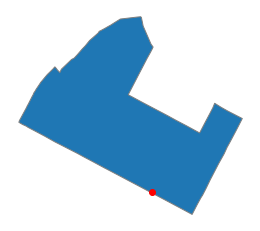

In [128]:
ax = wilmingtonpc.plot(edgecolor='grey')
ax.plot(wilmington.coords[0][0], wilmington.coords[0][1], 'ro')
ax.axis('off');

Fig 2: the distric twhere the center of Wilmington is, which is distric 100, is plotted. Wilmington center (coordinates 39.7447° N, 75.5484° W) is plotted as a red dot.

In [ ]:
print("precinct %d has %d rook and %d queens weights"%(wilmingtonpcid, 
rook_DE.cardinalities[wilmingtonpcid], 
queens_DE.cardinalities[wilmingtonpcid]))


precinct 100 has 7 rook and 9 queens weights


## make a connection plot: plot the neighborhood of the Wilmington center precincts and the Rook and Queens weights on it. 


Reproduce the diagram that shows the connectivity of the precints, the weights diagram (see notebook example https://github.com/fedhere/PUS2020_FBianco/blob/master/classdemo/SpatialWeights_CitiBike.ipynb) can you see which neighbourhood assignments are different for the rook and the queens weights? can you tell why?


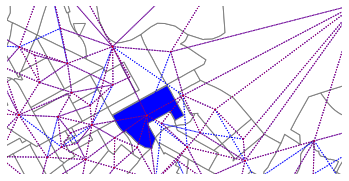

In [ ]:
# remove
ax = de_elecmap_ft.plot(edgecolor='grey', facecolor='w')
ax = wilmingtonpc.to_crs(epsg=2263).plot(edgecolor='grey', facecolor='b', ax=ax)
f,ax = queens_DE.plot(de_elecmap_ft, ax=ax, 
        edge_kws=dict(color='b', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
f,ax = rook_DE.plot(de_elecmap_ft, ax=ax, 
        edge_kws=dict(color='r', linestyle=':', alpha=0.5, linewidth=1),
        node_kws=dict(marker=''))


ax.set_axis_off()

plt.xlim((540000, 560000))
plt.ylim((-145000, -155000.));


Fig 3: cardinalities of the district where wilmington center is: the queens weights show, as expected, additional connection with districts that share a single point boundary in the giedataframe, e.g. the district on the top right corner of the district plotted in blue

In [ ]:
import pysal.lib as ps

# create the spatial lag metrics and calculate the global Moran's I

In [ ]:
# remove
voterturnoutlag = ps.weights.lag_spatial(queens_DE, de_elecmap_ft.voterturnout)
redvoteslag = ps.weights.lag_spatial(queens_DE, de_elecmap_ft.redvotes)
bluevoteslag = ps.weights.lag_spatial(queens_DE, de_elecmap_ft.bluevotes)

In [ ]:
# leave
np.where(de_elecmap_ft.voterturnout.isna())

(array([], dtype=int64),)

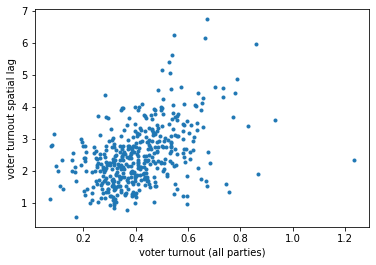

In [ ]:
# leave
plt.plot(de_elecmap_ft.voterturnout, voterturnoutlag, '.')
plt.xlabel("voter turnout (all parties)")
plt.ylabel("voter turnout spatial lag");

Figure 4: spatial lag plot of the voters "turnout" as defined in Figure 1, plotted against the voter turnour. The plot shows little correlation and it is further investigated below

In [ ]:
ball, aall = np.polyfit(de_elecmap_ft.voterturnout.values, voterturnoutlag, 1)
br,ar = np.polyfit(de_elecmap_ft.redvotes.values, redvoteslag, 1)
bb,ab = np.polyfit(de_elecmap_ft.bluevotes.values, bluevoteslag, 1)


## following the notebook example in class make a Moran'sI plot of each:
-all votes

-red votes

-blue votes

what do you notice?


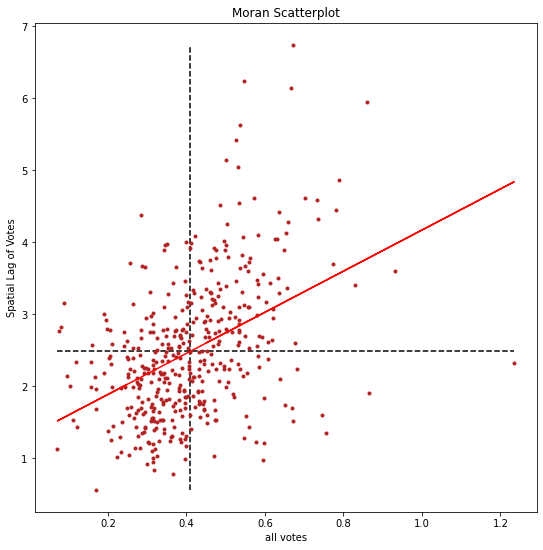

In [ ]:
# remove
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(de_elecmap_ft.voterturnout.values, voterturnoutlag, 
         '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(de_elecmap_ft.voterturnout.values.mean(), 
           voterturnoutlag.min(), 
           voterturnoutlag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(voterturnoutlag.mean(), 
           de_elecmap_ft.voterturnout.values.min(), 
           de_elecmap_ft.voterturnout.values.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(de_elecmap_ft.voterturnout.values , 
         aall + ball * de_elecmap_ft.voterturnout.values, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Votes')
plt.xlabel('all votes');

Figure 5: moorans I ov voter turnout regardless of party: the diagonal line represent a like fit to the point, which is positive indicating positive autocorrelation

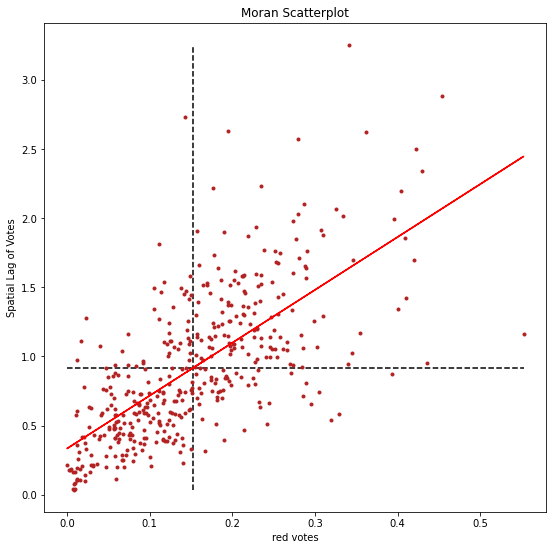

In [ ]:
# remove
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(de_elecmap_ft.redvotes.values, redvoteslag, 
         '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(de_elecmap_ft.redvotes.values.mean(), 
           redvoteslag.min(), 
           redvoteslag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(redvoteslag.mean(), 
           de_elecmap_ft.redvotes.values.min(), 
           de_elecmap_ft.redvotes.values.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(de_elecmap_ft.redvotes.values, 
         ar + br * de_elecmap_ft.redvotes.values, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Votes')
plt.xlabel('red votes');

Figure 6: moorans I ov voter turnout of republican votes: the diagonal line represent a like fit to the point, which is positive indicating positive autocorrelation. The points are aligned more tightly along the diagonal indicating a stronger spatial correlation

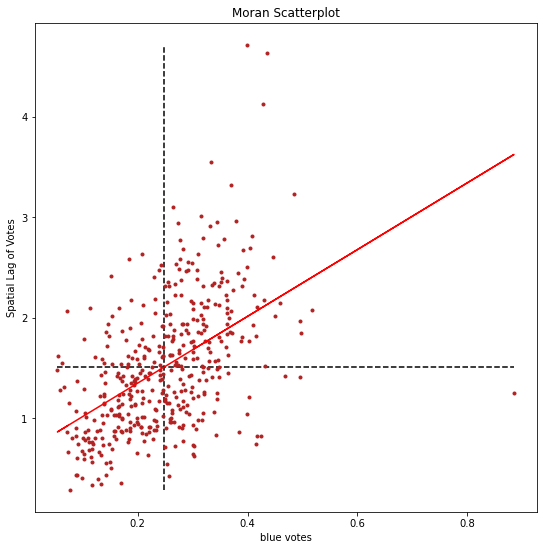

In [ ]:
# remove
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(de_elecmap_ft.bluevotes.values, bluevoteslag, 
         '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(de_elecmap_ft.bluevotes.values.mean(), 
           bluevoteslag.min(), 
           bluevoteslag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(bluevoteslag.mean(), 
           de_elecmap_ft.bluevotes.values.min(), 
           de_elecmap_ft.bluevotes.values .max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(de_elecmap_ft.bluevotes.values, 
         ab + bb * de_elecmap_ft.bluevotes.values, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Votes')
plt.xlabel('blue votes');

Figure 6: moorans I ov voter turnout of democtar votes: the diagonal line represent a like fit to the point, which is positive indicating positive autocorrelation. The points are aligned less tightly than in both the generic and republican votes  along the diagonal indicating a weaker spatial correlation

# Follow the notebook to complete the *local* spatial analysis. 
# how can you interpret these results ? (we will talk about it in class on Monday too)

In [ ]:
from pysal.explore import esda

In [ ]:
mi1 = esda.Moran(voterturnoutlag, queens_DE)
mi2 = esda.Moran(redvoteslag, queens_DE)
mi3 = esda.Moran(bluevoteslag, queens_DE)


In [ ]:
for v, mi in zip(("all", "red", "blue"), (mi1, mi2, mi3)) :
  print("the global Moran's I for " + 
      "{} is {:.2f}\nwhich corresponds to a p-value of the spatial distribution being random {:.2g}".format(
   v, mi.I, mi.p_sim))

the global Moran's I for all is 0.29
which corresponds to a p-value of the spatial distribution being random 0.001
the global Moran's I for red is 0.67
which corresponds to a p-value of the spatial distribution being random 0.001
the global Moran's I for blue is 0.42
which corresponds to a p-value of the spatial distribution being random 0.001


All Moran's I coefficients are positive and statistically significant at a p<0.05 , in dicating there is positive autocorrelation in the voters turnout globally, as well as by partisan lines. The largest coefficient is for the republican votes, indicating the most significant spatial correlation: neighborhood vote red more cohesively. The weakest correlation is for the overall voters turnout.

In [ ]:
LMo_red = esda.Moran_Local(de_elecmap_ft.redvotes.values, queens_DE, permutations=9999)


In [ ]:
LMo_blue = esda.Moran_Local(de_elecmap_ft.bluevotes.values, queens_DE, permutations=9999)


In [ ]:
sig = LMo_red.p_sim < 0.01
hotspotsR = LMo_red.q==1 * sig
coldspotsR = LMo_red.q==3 * sig
print ("Number of Hotspots:", hotspotsR.sum())
print ("Number of Coldspots:", coldspotsR.sum())

Number of Hotspots: 36
Number of Coldspots: 59


In [ ]:
sig = LMo_blue.p_sim < 0.01
hotspotsB = LMo_blue.q==1 * sig
coldspotsB = LMo_blue.q==3 * sig
print ("Number of Hotspots:", hotspotsB.sum())
print ("Number of Coldspots:", coldspotsB.sum())

Number of Hotspots: 35
Number of Coldspots: 49


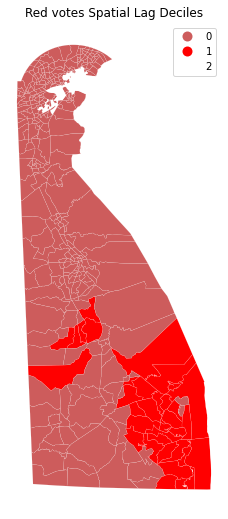

In [ ]:
from matplotlib import colors

hcmap = colors.ListedColormap(['Indianred','red','white'])
hotcold = hotspotsR*1 + coldspotsR*2

f, ax = plt.subplots(figsize=(9, 9))
de_elecmap_ft.assign(cl=hotcold).plot(column='cl', categorical=True, 
        k=3, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Red votes Spatial Lag Deciles");

Figure 7: hot sports of red votes, as measured by the spacial lag with a significance of 0.01, are see in lower delaware, particularly along the cost. Low red voting areas are seen in the urban Wilmington region

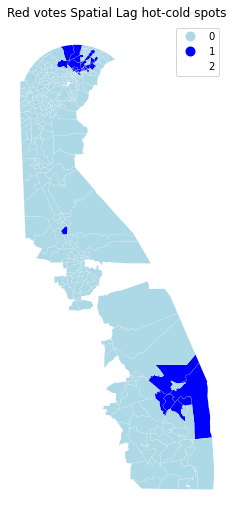

In [ ]:

hcmap = colors.ListedColormap(['lightblue','blue','white'])
hotcold = hotspotsB*1 + coldspotsB*2

f, ax = plt.subplots(figsize=(9, 9))
de_elecmap_ft.assign(cl=hotcold).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Red votes Spatial Lag hot-cold spots");

Figure 8: hot sports of blue votes, as measured by the spacial lag with a significance of 0.01, are seen in the urban Wilmington region as well as in the lower delaware coast, which was also showing high red turnout.